## 데이터 : 캐글 데이터 / 아마존 홈페이지 내 존재하는 도서 데이터 프레임
- 사용하는 변수는 책 제목, 이미지, 줄거리 입니다.

## 목표점
- 책 제목을 입력했을 때 해당하는 줄거리와 다른 도서들의 줄거리 간 유사도를 분석하여 가장 유사한 추천 도서 표지 출력하기

## 진행사항
1. 데이터 전처리 (줄거리 변수의 값들에 대한 토큰화 진행)
2. 보잘것 없는 Word2vec 분석 (모든 줄거리들 내에 존재하는 1개의 단어를 입력하면 유사한 단어들/유사도 출력)
3. 도서 표지 이미지 출력 (그냥 구글링 코드 / 추후에는 추천 도서 5개를 출력하도록 하자.)

In [209]:
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('D:\\python__\\books_data.csv')
df = df[['Title', 'image','description']]                                     # 필요 변수만

df = df.dropna(axis = 0, how = 'any')                                         # 결측지 제거

# np.random.seed(123)
# label = np.random.randint(0,len(df),130000)                                     # 데이터 수가 너무 많아서 7000개 랜덤으로 추출
# df = df.iloc[label].reset_index()
# del df['index']

In [210]:
df.describe()   # 줄거리 중복값이 많음

,Title,image,description
count,126531,126531,126531
unique,126531,126531,126450
top,Dr. Seuss: American Icon,http://books.google.com/books/content?id=IjvHQ...,find information rowman littlefield titles ple...
freq,1,1,3


In [211]:
df = df.drop_duplicates('description')    # 중복값 제거 데이터프레임 생성
df.index = range(len(df))    # 인덱스 재지정
df

,Title,image,description
0,Dr. Seuss: American Icon,http://books.google.com/books/content?id=IjvHQ...,philip nel takes fascinating look key aspects ...
1,Wonderful Worship in Smaller Churches,http://books.google.com/books/content?id=2tsDA...,resource includes twelve principles understand...
2,Whispers of the Wicked Saints,http://books.google.com/books/content?id=aRSIg...,julia thomas finds life spinning control death...
3,The Church of Christ: A Biblical Ecclesiology ...,http://books.google.com/books/content?id=kVqRa...,church christ biblical ecclesiology today resp...
4,Saint Hyacinth of Poland,http://books.google.com/books/content?id=lmLqA...,story children 10 st. hyacinth dominican plant...
...,...,...,...
126445,Autodesk Inventor 10 Essentials Plus,http://books.google.com/books/content?id=zxHRC...,autodesk inventor 2017 essentials plus provide...
126446,The Orphan Of Ellis Island (Time Travel Advent...,http://books.google.com/books/content?id=J7M-N...,school trip ellis island dominick avaro ten-ye...
126447,Red Boots for Christmas,http://books.google.com/books/content?id=3n8k6...,everyone village friedensdorf happily preparin...
126448,The Autograph Man,http://books.google.com/books/content?id=JM6YV...,alex-li tandem sells autographs business hunt ...


In [212]:
df_title = df.Title.copy()
df_des = df.description.copy()

In [213]:
df_des   # 전처리할 데이터

0         philip nel takes fascinating look key aspects ...
1         resource includes twelve principles understand...
2         julia thomas finds life spinning control death...
3         church christ biblical ecclesiology today resp...
4         story children 10 st. hyacinth dominican plant...
                                ...                        
126445    autodesk inventor 2017 essentials plus provide...
126446    school trip ellis island dominick avaro ten-ye...
126447    everyone village friedensdorf happily preparin...
126448    alex-li tandem sells autographs business hunt ...
126449    discover many ways mathematics relevant life m...
Name: description, Length: 126450, dtype: object

# 데이터 전처리

In [64]:
def NLTK_des(data):
    
    data = data.str.lower()     # 소문자 변경
    
    nltk.download('punkt')
    nltk.download('stopwords')
    
    stw = stopwords.words('english')   # 불용어
    stw.extend(["'s", "’", "’", "''", "``", "--"])    # 불용어 + punctuation에 없는 특수문자들

    des_token = []

    for i in range(len(data)):
        result = []
        for w in word_tokenize(data[i]):
            if ((w not in stw) and (w not in punctuation)):
                result.append(w)
                tmp = " ".join(result)
        des_token.append(tmp)

    return pd.Series(des_token)


# NLTK_des(df_des)

In [65]:
df['description'] = NLTK_des(df_des)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
df.to_csv("project_2.csv", index = False)

# Word2vec 학습 
<br>

### 여기서부턴 온갖 구글링에 시달린 코드들 중 일부입니다.
### 어찌저찌 Word2vec으로 단어들 간 유사도는 찾았는데 신뢰하기에는 어려운 결과값으로 추정됩니다.

In [50]:
corpus = NLTK_des(df_des).str.split()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
corpus = df_des.str.split()

In [7]:
model = Word2Vec(sentences = corpus, vector_size = 100,window=5, min_count = 50, workers=4, sg=0)

In [125]:
model_result = model.wv.most_similar("soccer")
print(model_result)

[('tennis', 0.837067186832428), ('hockey', 0.7782438397407532), ('football', 0.7499709129333496), ('basketball', 0.7305560111999512), ('nfl', 0.7271896004676819), ('poker', 0.720195472240448), ('coaches', 0.7045086026191711), ('athlete', 0.694114625453949), ('coach', 0.6808311939239502), ('player', 0.6805670261383057)]


In [126]:
i_list = []
j_list = []
for i, j in model_result:
    i_list.append(i)
    j_list.append(j)
plo = pd.DataFrame({'name' : i_list, 'prob': j_list})
plo

,name,prob
0,tennis,0.837067
1,hockey,0.778244
2,football,0.749971
3,basketball,0.730556
4,nfl,0.727190
5,poker,0.720195
6,coaches,0.704509
7,athlete,0.694115
8,coach,0.680831
9,player,0.680567


# 새로운 코드

In [250]:
# 제 컴퓨터로는 데이터 개수를 줄여야 돌아갑니다...
df1 = df.head(40000).copy()

In [260]:
df1.head(30)

,Title,image,description
0,Dr. Seuss: American Icon,http://books.google.com/books/content?id=IjvHQ...,philip nel takes fascinating look key aspects ...
1,Wonderful Worship in Smaller Churches,http://books.google.com/books/content?id=2tsDA...,resource includes twelve principles understand...
2,Whispers of the Wicked Saints,http://books.google.com/books/content?id=aRSIg...,julia thomas finds life spinning control death...
3,The Church of Christ: A Biblical Ecclesiology ...,http://books.google.com/books/content?id=kVqRa...,church christ biblical ecclesiology today resp...
4,Saint Hyacinth of Poland,http://books.google.com/books/content?id=lmLqA...,story children 10 st. hyacinth dominican plant...
5,Muslim Women's Choices: Religious Belief and S...,http://books.google.com/books/content?id=o7izA...,counters western views stereotypes muslim wome...
6,Dramatica for Screenwriters,http://books.google.com/books/content?id=iTueu...,dramatica screenwriters armando saldana mora m...
7,Mensa Number Puzzles (Mensa Word Games for Kids),http://books.google.com/books/content?id=tX1Is...,acclaimed teacher puzzler evelyn b. christense...
8,Vector Quantization and Signal Compression (Th...,http://books.google.com/books/content?id=GgnrB...,herb caen popular columnist san francisco chro...
9,A husband for Kutani,http://books.google.com/books/content?id=EzxOD...,first published 1938 collection four oriental ...


In [251]:
co1 = df1.description.copy()

In [253]:
co1

0        philip nel takes fascinating look key aspects ...
1        resource includes twelve principles understand...
2        julia thomas finds life spinning control death...
3        church christ biblical ecclesiology today resp...
4        story children 10 st. hyacinth dominican plant...
                               ...                        
39995    young crocodile vivid imagination celebrates b...
39996    awakening deep coma induced car accident maggi...
39997    billy cutshaw former astronaut fell madness li...
39998    presents history native american white relatio...
39999    animals matter examines barriers philosophical...
Name: description, Length: 40000, dtype: object

In [255]:
# TF - IDF 기법으로 벡터화
# 20000개의 줄거리는 80120개의 단어로 이루어져있다. (전처리 완료돼서 많이 줄었다.)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(co1)
print('TF-IDF 행렬의 크기(shape) :',tf_idf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (40000, 109378)


In [256]:
# 전체 유사도 계산
cos_sim = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
print('코사인 유사도 연산 결과 :',cos_sim.shape)

코사인 유사도 연산 결과 : (40000, 40000)


In [257]:
title_idx = dict(zip(df1['Title'], df1.index))

# 도서 제목 입력하면 인덱스를 리턴
idx = title_idx['Whispers of the Wicked Saints']
print(idx)

2


In [258]:
def Recommend(title, cos_sim=cos_sim):
    
    # 도서 제목 입력하면 인덱스를 리턴
    idx = title_idx[title]

    # 도서 줄거리 유사도 전부 가져오기
    sim = list(enumerate(cos_sim[idx]))

    # 유사도에 따라 정렬하기
    sim = sorted(sim, key=lambda x: x[1], reverse=True)

    # 유사도 탐10 가져오기
    sim = sim[1:11]

    # 유사도 탑10 인덱스 가져오기
    rec_idx = [idx[0] for idx in sim]

    # 유사도 탑10 제목 가져오기
    print(sim)                       # (인덱스, 유사도)
    return df['Title'].iloc[rec_idx]

In [264]:
Recommend('Dramatica for Screenwriters')

[(7447, 0.13958581079499), (31849, 0.1364071994029109), (31505, 0.12278285476139225), (30181, 0.10773907478486691), (25579, 0.09907907197930815), (22847, 0.09277400339360702), (10080, 0.07755153740134275), (11613, 0.07638293593424088), (5946, 0.07589743229775141), (4083, 0.07424973062471811)]


7447                             Screenwriting For Dummies
31849    Best American Screenplays 3: Complete Screenpl...
31505    Spice World: The Movie: The Official Book of t...
30181    J. B. Lightfoot's Commentary on the Epistles o...
25579    Acts of Teaching: How to Teach Writing: A Text...
22847                      Secrets of Screenplay Structure
10080    The Love of a D-Girl: A Novel of Sex, Lies, an...
11613    Characters, Emotion & Viewpoint: Techniques an...
5946                        Tiberius: The Resentful Caesar
4083                            USMLE Step 2 Mock Exam, 1e
Name: Title, dtype: object

In [261]:
a = Recommend('Dramatica for Screenwriters')

[(7447, 0.13958581079499), (31849, 0.1364071994029109), (31505, 0.12278285476139225), (30181, 0.10773907478486691), (25579, 0.09907907197930815), (22847, 0.09277400339360702), (10080, 0.07755153740134275), (11613, 0.07638293593424088), (5946, 0.07589743229775141), (4083, 0.07424973062471811)]


In [262]:
a.index[9]

4083

# 책 표지 사진 불러오기
<br>

### 아래 코드를 이용해서 뭔가 더 좋은 시각자료를 출력할 수 있을 것 같습니다.

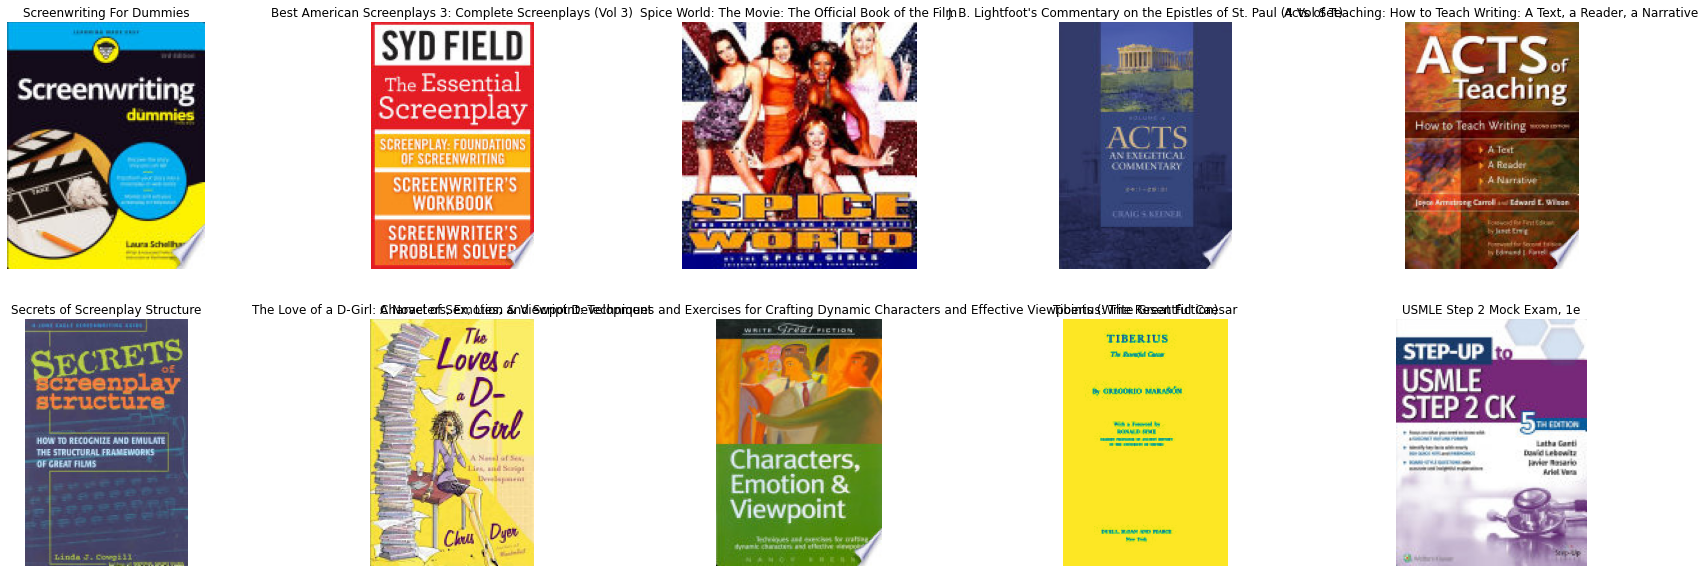

In [263]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 10))
plt.tight_layout()

for i in range(10):
    response = requests.get(df1.loc[a.index[i]].image)
    img = Image.open(BytesIO(response.content))
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df1.loc[a.index[i]]['Title'])

# ↓ 실패 코드들

In [36]:
def Title_scale(data):

    data = data.str.lower()                                         # 소문자
    ti = data

    ti_list = []
    for i in range(len(data)):
        ti_tmp = [i for i in list(data[i]) if i not in punctuation]       # 특수문자
        ti_s = "".join(ti_tmp)
        ti_list.append(ti_s)

    for j in range(len(data)):                                                  # 띄어쓰기 2번 되어있는 것들
        a = ""
        for i in ti_list[j].split():
            a += (" " + i)
        ti_list[j] = a.strip()
   #     df1.Title = pd.Series(ti_list)

    return pd.Series(ti_list)


def Ti_eng(data):
    stop_words = set(stopwords.words('english')) 
    ti_eng = []

    for i in range(len(data)):
        result = []
        for t in data[i].split(): 
            if t not in stop_words: 
                result.append(t)
                d = " ".join(result)       
        ti_eng.append(d)
   # df1.description = pd.Series(des_eng)
    
    return pd.Series(ti_eng)

In [261]:
def Des_scale(data):

    data = data.str.lower()
    de = data

    de_list = []
    for i in range(len(data)):
        de_tmp = [i for i in list(data[i]) if i not in punctuation]
        de_s = "".join(de_tmp)
        de_list.append(de_s)

    for j in range(len(data)):
        b = ""
        for i in de_list[j].split():
            b += (" " + i)
        de_list[j] = b.strip()
       # df1.description = pd.Series(de_list)

        return pd.Series(de_list)
    
    
    
def Des_eng(data):
    stop_words = set(stopwords.words('english')) 
    des_eng = []

    for i in range(len(data)):
        result = []
        for t in data[i].split(): 
            if t not in stop_words: 
                result.append(t)
                c = " ".join(result)       
        des_eng.append(c)
   # df1.description = pd.Series(des_eng)
    
    return pd.Series(des_eng)

# ↑ 실패 코드들

In [178]:
# 구글링으로 얻어낸 라이브러리들 (다 쓰지는 않음)
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity